In [2]:
#loading libraries
import pandas as pd
import os, os.path
import re
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
import math
import time
import datetime

In [3]:
#concatnar os ficheiros
# dir="c:/Users/Leonardo Moreira/Documents/Projetos/Smart Weighing - Cachapuz Bilanciai/Dados/data/weighings/weighings_partition1.json"
def load_data():
    import pandas as pd
    dir="c:/Users/Leonardo Moreira/Documents/Projetos/Smart Weighing - Cachapuz Bilanciai/Dados/data/weighings_2/weighings_partition1.json"

    # contar o nº de ficheiros para concatnar
    # files_number=len([name for name in os.listdir('.') if os.path.isfile(name)])-1
    files_number=20

    # concatnar os ficheiros num único dataframe
    for i in range(files_number):
        if i==0:
            data=pd.read_json(dir)
        else:
            data=data.append(pd.read_json(dir))
            
        dir=dir.replace("partition{}".format(i+1),"partition{}".format(i+2))

    return data

    #Objectivo da função: Remover o pattern ".0" da coluna cellSerialNumber_X do dataframe. Remover também o pattern de início "0" se o serialNumber não começar com "00".
#inputs: 
# string que corresponda ao header da coluna com os cellSerialNumbers,
# exemplo 'cellSerialNumber_0'
#Transformar os cellSerialNumbers que terminam com ".0" ou que comecem com "0" (não remover o "0" se a string começar com "00")
def Clean_names(CellSerialNumber):
    import re
    if re.search('\.0', CellSerialNumber):
        pos_2=re.search('\.0', CellSerialNumber).start()
    else:
        pos_2=len(CellSerialNumber)
                
    if re.match('00', CellSerialNumber)==None and re.match('0', CellSerialNumber):
        pos_1=1
    else:
        pos_1=0
    return CellSerialNumber[pos_1:pos_2]


def clean_dataframe(data):
#Remover as colunas das cellIds visto que não interessam para o caso
    cellIdsList=['cellId_0','cellId_1','cellId_2','cellId_3','cellId_4','cellId_5','cellId_6','cellId_7']
    data=data.drop(cellIdsList, axis=1)
# Remover dados duplicados 
    data=data.drop_duplicates(subset='_id', keep="last")
# Ordenar por data
    data=data.sort_values(by=['timestamp']) 
#Dar reset aos indexes
    data=data.reset_index(drop=True)
    
#Converter os cellSerialNumbers para strings
    a="cellSerialNumber_0"
    for i in range(8):
        #Transformar os cellSerialNumbers em strings
        data[a]=data[a].astype(str)
        #Remover o pattern ".0" da coluna cellSerialNumber_X do dataframe. Remover também o pattern de início "0" se o serialNumber não começar com "00".
        data[a]=data[a].apply(Clean_names)
        a=a.replace("cellSerialNumber_{}".format(i),"cellSerialNumber_{}".format(i+1))
        
    return data

In [4]:
#Load data
dataset=load_data()
#Clean the dataframe columns, remove duplicates, order by time, reset the indexes, ensure standard names
dataset=clean_dataframe(dataset)

In [5]:
#Selecionar a ponte báscula P191021852
weighbridge=cp.deepcopy(dataset[dataset['scaleSerialNumber']=='P191021852'])
#Reset aos indexes da weighbridge
weighbridge=weighbridge.reset_index(drop=True)

In [6]:
weighbridge['cellSerialNumber_0'].unique()

array(['7450332', '7450338', '7450339', '7450333', '7450340', '7450337',
       '7450336', '7450341', 'nan', 'None'], dtype=object)

In [7]:
#Construir um dataframe que contenha as pesagens por cellSerialNumber

cellIdsList=['7450332','7450333','7450339','7450340','7450338','7450337','7450336','7450341']

a='cellSerialNumber_7'
b='cellWeight_7'

Nan_array=np.empty(len(weighbridge))
Nan_array[:]=np.NaN
Nan_dataframe=pd.DataFrame(data=Nan_array,columns=['cellWeight_0'])
SerialNumber_dataframe=cp.deepcopy(Nan_dataframe)

for i in range(len(cellIdsList)):
    aux=len(cellIdsList)-1-i
    e="cellSerialNumber_{}".format(aux-1)
    f='cellWeight_{}'.format(aux-1)
    
    SerialNumber_dataframe[:]=cellIdsList[7-i]
    
    for j in range(aux):
        weighbridge[a]=weighbridge[a].mask((weighbridge[e]==cellIdsList[aux]),weighbridge[e])
        weighbridge[b]=weighbridge[b].mask((weighbridge[e]==cellIdsList[aux]),weighbridge[f])
        
        e=e.replace("cellSerialNumber_{}".format(aux-1-j),"cellSerialNumber_{}".format(aux-1-(j+1)))
        f=f.replace("cellWeight_{}".format(aux-1-j),"cellWeight_{}".format(aux-1-(j+1)))
    
    weighbridge[b]=weighbridge[b].mask((weighbridge[a]!=cellIdsList[7-i]),Nan_dataframe['cellWeight_0'])
    weighbridge[a]=weighbridge[a].mask((weighbridge[a]!=cellIdsList[7-i]), SerialNumber_dataframe['cellWeight_0'])
    
    a=a.replace("cellSerialNumber_{}".format(7-i),"cellSerialNumber_{}".format(7-(i+1)))
    b=b.replace("cellWeight_{}".format(7-i),"cellWeight_{}".format(7-(i+1)))

# Substituir no dataframe os Nans pelos valores anteriores
weighbridge.fillna(method='ffill', inplace=True)

In [8]:
weighbridge['cellSerialNumber_0'].unique()

array(['7450332'], dtype=object)

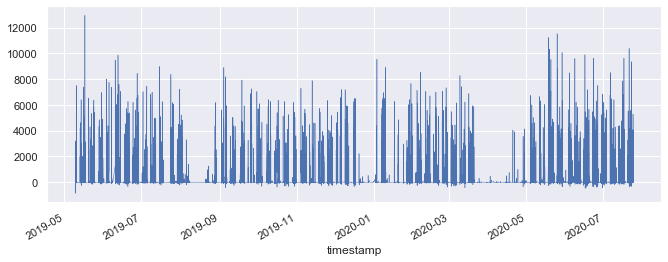

In [11]:
sns.set(rc={'figure.figsize':(11,4)})
weighbridge_plot=weighbridge.set_index('timestamp')
weighbridge_plot['cellWeight_0'].plot(linewidth=0.5)

In [16]:
len(weighbridge['cellWeight_0'])

423069

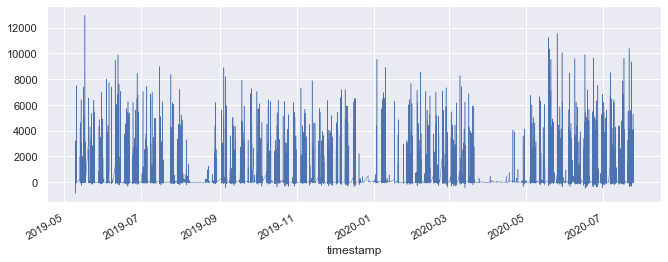

In [17]:
lc_0_ts=cp.deepcopy(weighbridge[['timestamp','cellWeight_0']])

for i in range(len(lc_0_ts['timestamp'])):
    if i!=0:
        if abs(lc_0_ts['cellWeight_0'].iloc[i]-lc_0_ts['cellWeight_0'].iloc[i-1])>10:
            timestamp_list.append(lc_0_ts['timestamp'].iloc[i])
    else:
        timestamp_list=[lc_0_ts['timestamp'].iloc[i]]

lc_0_ts=lc_0_ts[lc_0_ts['timestamp'].isin(timestamp_list)]

weighbridge_plot=lc_0_ts.set_index('timestamp')
weighbridge_plot['cellWeight_0'].plot(linewidth=0.5)

TRANSFORMING A TIME-SERIES TO AN ANGULAR IMAGE:
1. CHOOSE A LOAD CELL
2. STORE THE TIME-SERIES OF THAT LOAD CELL
3. NORMALIZE THE TIME-SERIES WITH MIN-MAX TO OBTAIN SCALED DATA (b)
4. CONVERT SCALED TIME-SERIES TO POLAR COORDINATES: theta=arccos(b); r=timestamp/1
5. CALCULAR O GASF(GRAMIAN ANGULAR SUMMATION FIELD) & GADF(GRAMIAN ANGULAR DIFFERENCE FIELD): GASF_i,j=cos(theta_i+theta_j); GADF_i,j=sin(theta_i-theta_j)
6. DONE

In [18]:
len(lc_0_ts)

26613

In [93]:
lc_0_ts=cp.deepcopy(weighbridge[['timestamp','cellWeight_0']])

for i in range(len(lc_0_ts['timestamp'])):
    if i!=0:
        if lc_0_ts['cellWeight_0'].iloc[i]!=lc_0_ts['cellWeight_0'].iloc[i-1]:
            timestamp_list.append(lc_0_ts['timestamp'].iloc[i])
    else:
        timestamp_list=[lc_0_ts['timestamp'].iloc[i]]

lc_0_ts=lc_0_ts[lc_0_ts['timestamp'].isin(timestamp_list)]

lc_0_ts_scaled=cp.deepcopy(lc_0_ts)
lc_0_ts_scaled['cellWeight_0']=minmax_scale(lc_0_ts['cellWeight_0'])
lc_0_ts_scaled['cellWeight_0']=lc_0_ts_scaled['cellWeight_0'].apply(math.acos)
lc_0_ts_scaled['timestamp']=lc_0_ts_scaled['timestamp'].astype(np.int64) // 10**9


IN ORDER TO CREATE THE MATRICES GASF AND GADF, IT IS FIRST NECESSARY TO REDUCE THE TIME-SERIES [PROBLEMS WITH MEMORY CAPACITY]. ONE APPROACH TO DO SO IS TO REMOVE MOST OF 0 VALUES.

In [94]:
timestamp_size=len(lc_0_ts_scaled['timestamp'])
GASF=np.zeros((int((timestamp_size-1)/2),int((timestamp_size-1)/2)))
#GADF=np.zeros((timestamp_size,timestamp_size))

#dataframe=pd.DataFrame(data=)
#for i in range(timestamp_size):
#    for j in range(timestamp_size):
#        GASF

MemoryError: Unable to allocate 6.76 GiB for an array with shape (30126, 30126) and data type float64

In [76]:
lc_0_ts_scaled

,timestamp,cellWeight_0
0,1557411775,1.508482
1,1557411778,1.508482
2,1557411781,1.508482
3,1557411784,1.508482
4,1557412240,1.508482
...,...,...
423064,1595598368,1.507757
423065,1595598370,1.508482
423066,1595598372,1.508482
423067,1595598373,1.508482


CONSTRUIR CNN

In [23]:
weighbridge

,_id,timestamp,terminalSerialNumber,scaleSerialNumber,scaleGross,scaleNet,cellSerialNumber_0,cellWeight_0,cellSerialNumber_1,cellWeight_1,...,cellSerialNumber_3,cellWeight_3,cellSerialNumber_4,cellWeight_4,cellSerialNumber_5,cellWeight_5,cellSerialNumber_6,cellWeight_6,cellSerialNumber_7,cellWeight_7
0,5cd43963a61883ad63c5835e,2019-05-09 14:22:55,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
1,5cd43965a618830094c58367,2019-05-09 14:22:58,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
2,5cd43968a61883e53ac58370,2019-05-09 14:23:01,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
3,5cd4396ba618835713c58379,2019-05-09 14:23:04,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
4,5cd43b33a61883db28c58384,2019-05-09 14:30:40,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423064,5f1ae66137b06e0008514ebf,2020-07-24 13:46:08,160690,P191021852,0.0,0.0,7450332,10.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
423065,5f1ae66337b06e0008514ec8,2020-07-24 13:46:10,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,10.0
423066,5f1ae66537b06e0008514ed1,2020-07-24 13:46:12,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
423067,5f1ae66737b06e0008514ed7,2020-07-24 13:46:13,160690,P191021852,0.0,0.0,7450332,0.0,7450333,0.0,...,7450340,0.0,7450338,0.0,7450337,0.0,7450336,0.0,7450341,0.0
